# Evaluate IR with LLMs
 - This notebook reads the original dataset and the extracted dataset and **computes an evaluation for the extracted sentiment and tickers by comparing extracted info wrt the gound truth in the original dataset**.
 - No need for dataset split into training/valiadation/test as for the inference we used a pre-trained LLM.
 - Note: the original and extracted datasets did not have an id to match entries. This has been done later in notebook **AddIdsToDatasets.ipynb**

# Load original (ground truth) and extracted Datasets

In [143]:
import json 
import os
import pandas as pd
from sklearn.metrics import classification_report
from difflib import SequenceMatcher

# Paths to datasets
DATA_DIR = '../data/polygon'
ORIGINAL_JSON_PATH = os.path.join(DATA_DIR, 'financial_news_with_ticker_level_sentiment.json')
EXTRACTED_JSON_PATH = os.path.join(DATA_DIR, 'extracted_structured_data.json')

# Load datasets
with open(ORIGINAL_JSON_PATH, 'r', encoding='utf-8') as f:
    original_data = json.load(f)
original_df = pd.DataFrame(original_data)

with open(EXTRACTED_JSON_PATH, 'r', encoding='utf-8') as f:
    extracted_data = json.load(f)
extracted_df = pd.DataFrame(extracted_data)

# Ensure both datasets have the same number of entries
min_length = min(len(original_df), len(extracted_df))
original_df = original_df.iloc[:min_length]
orig_extracted_df = extracted_df.iloc[:min_length]

In [108]:
original_df

,article_url,author,description,id,image_url,amp_url,keywords,published_utc,publisher,tickers,insights,title
0,https://www.zacks.com/stock/news/2114673/alleg...,Zacks.com,Allegiant Travel (ALGT) is a fast-moving stock...,0,https://staticx-tuner.zacks.com/images/default...,None,"[Allegiant Travel, momentum investing, fast-pa...",2023-06-29T12:50:06Z,"{'name': 'Zacks Investment Research', 'homepag...",[ALGT],"[{'ticker': 'ALGT', 'sentiment': 'positive', '...",Allegiant Travel (ALGT) Is Attractively Priced...
1,https://www.zacks.com/stock/news/2085677/appli...,Zacks.com,Applied Industrial Technologies (AIT) reported...,1,https://staticx-tuner.zacks.com/images/default...,None,"[earnings, revenues, estimates, industrial pro...",2023-04-27T11:55:14Z,"{'name': 'Zacks Investment Research', 'homepag...","[AIT, NPO]","[{'ticker': 'AIT', 'sentiment': 'positive', 's...",Applied Industrial Technologies (AIT) Q3 Earni...
2,https://www.globenewswire.com/news-release/202...,N/A,"Apollo Commercial Real Estate Finance, Inc. (A...",2,https://ml.globenewswire.com/Resource/Download...,None,"[commercial real estate, financing, mortgage l...",2023-03-06T13:30:00Z,"{'name': 'GlobeNewswire Inc.', 'homepage_url':...","[ARI, SAN]","[{'ticker': 'ARI', 'sentiment': 'positive', 's...","Apollo Commercial Real Estate Finance, Inc. Cl..."
3,https://www.globenewswire.com/news-release/202...,N/A,"Maravai LifeSciences, a global provider of lif...",3,https://ml.globenewswire.com/Resource/Download...,None,"[Maravai LifeSciences, investor conferences, f...",2023-11-09T13:15:00Z,"{'name': 'GlobeNewswire Inc.', 'homepage_url':...",[MRVI],"[{'ticker': 'MRVI', 'sentiment': 'positive', '...",Maravai LifeSciences Announces November 2023 I...
4,https://www.zacks.com/stock/news/2069321/dht-h...,Zacks Equity Research,"DHT Holdings, an independent oil tanker compan...",4,https://staticx-tuner.zacks.com/images/default...,None,"[DHT Holdings, oil tanker, earnings, revenue, ...",2023-03-22T22:00:25Z,"{'name': 'Zacks Investment Research', 'homepag...",[DHT],"[{'ticker': 'DHT', 'sentiment': 'neutral', 'se...",DHT Holdings (DHT) Stock Moves -1.33%: What Yo...
...,...,...,...,...,...,...,...,...,...,...,...,...
947,https://www.fool.com/investing/2023/07/09/ai-r...,The Motley Fool,Billionaires are investing heavily in Meta Pla...,947,https://g.foolcdn.com/editorial/images/738844/...,None,"[AI, Meta Platforms, Alphabet, Billionaires, I...",2023-07-09T14:30:00Z,"{'name': 'The Motley Fool', 'homepage_url': 'h...","[META, GOOG, GOOGL]","[{'ticker': 'META', 'sentiment': 'positive', '...",AI Revolution: 2 Artificial Intelligence Stock...
948,https://www.globenewswire.com/news-release/202...,N/A,"Host Hotels & Resorts, Inc. announced a 20% in...",948,https://ml.globenewswire.com/Resource/Download...,None,"[Host Hotels & Resorts, dividend, quarterly ca...",2023-09-14T20:30:00Z,"{'name': 'GlobeNewswire Inc.', 'homepage_url':...",[HST],"[{'ticker': 'HST', 'sentiment': 'positive', 's...",Host Hotels & Resorts Announces Increased Thir...
949,https://www.zacks.com/stock/news/2200385/chesa...,Zacks Equity Research,Chesapeake Utilities' subsidiary Sharp Energy ...,949,https://staticx-tuner.zacks.com/images/article...,None,"[Chesapeake Utilities, Sharp Energy, propane b...",2023-12-20T11:47:00Z,"{'name': 'Zacks Investment Research', 'homepag...",[CPK],"[{'ticker': 'CPK', 'sentiment': 'positive', 's...",Chesapeake Utilities' (CPK) Unit Buys Propane ...
950,https://www.zacks.com/stock/news/2088175/emerg...,Zacks.com,Emergent Biosolutions (EBS) is expected to rep...,950,https://staticx-tuner.zacks.com/images/default...,None,"[earnings, earnings estimates, earnings surpri...",2023-05-02T14:01:51Z,"{'name': 'Zacks Investment Research', 'homepag...","[EBS, ITCI]","[{'ticker': 'EBS', 'sentiment': 'positive', 's...",Emergent Biosolutions (EBS) Expected to Beat E...


In [109]:
orig_extracted_df.head(25)

,title,article_keywords,relevant_company_details,id
0,Allegiant Travel: Fast-Moving Stock with Stron...,"[Allegiant Travel, ALGT, stock, momentum, valu...","{'Allegiant Travel': {'ticker': 'ALGT', 'senti...",0
1,"AIT Q3 Results Beat Estimates, Stock to Perfor...","[Applied Industrial Technologies, Q3 results, ...",{'Applied Industrial Technologies': {'ticker':...,1
2,Apollo Commercial Real Estate Finance Secures ...,"[Apollo Commercial Real Estate Finance, Banco ...",{'Apollo Commercial Real Estate Finance': {'ti...,2
3,Maravai LifeSciences to present at investor co...,"[Maravai LifeSciences, investor conferences, N...",{'Maravai LifeSciences': {'ticker': 'tickerN/A...,3
4,DHT Holdings Stocks Down 1.33%,"[DHT Holdings, Transportation sector]","{'DHT Holdings': {'ticker': 'N/A', 'sentiment_...",4
5,Meta Platforms Q2 2023 Earnings: Impressive Ne...,"[Meta Platforms, Q2 2023 earnings, net profit,...","{'Meta Platforms': {'ticker': 'FB', 'sentiment...",5
6,Comcast's Entertainment Industry Recovery Amid...,"[Comcast, NBCUniversal, Peacock, theme parks, ...","{'Comcast': {'ticker': 'CMCSA', 'sentiment_rea...",6
7,Analysts increase Sarepta Therapeutics price t...,"[Sarepta Therapeutics, analysts, price target,...","{'Sarepta Therapeutics': {'ticker': 'SRPT', 's...",7
8,Stocks with Strong Value and Positive Outlook:...,"[Atmus Filtration Technologies Inc., Carrols R...",{'Atmus Filtration Technologies Inc.': {'ticke...,8
9,Celldex Therapeutics Q1 Earnings Beat Estimate...,"[Celldex Therapeutics, Quarterly Loss, Zacks C...",{'Celldex Therapeutics': {'ticker': 'tickerN/A...,9


In [136]:
orig_extracted_df

,title,article_keywords,relevant_company_details,id
0,Allegiant Travel: Fast-Moving Stock with Stron...,"[Allegiant Travel, ALGT, stock, momentum, valu...","{'Allegiant Travel': {'ticker': 'ALGT', 'senti...",0
1,"AIT Q3 Results Beat Estimates, Stock to Perfor...","[Applied Industrial Technologies, Q3 results, ...",{'Applied Industrial Technologies': {'ticker':...,1
2,Apollo Commercial Real Estate Finance Secures ...,"[Apollo Commercial Real Estate Finance, Banco ...",{'Apollo Commercial Real Estate Finance': {'ti...,2
3,Maravai LifeSciences to present at investor co...,"[Maravai LifeSciences, investor conferences, N...",{'Maravai LifeSciences': {'ticker': 'tickerN/A...,3
4,DHT Holdings Stocks Down 1.33%,"[DHT Holdings, Transportation sector]","{'DHT Holdings': {'ticker': 'N/A', 'sentiment_...",4
...,...,...,...,...
947,"Wynn Resorts Reports Q4 Loss, Revenues Beat Es...","[Wynn Resorts, Q4 earnings, revenues, loss, Za...","{'Wynn Resorts': {'ticker': 'WYNN', 'sentiment...",973
948,"Axogen reports Q3 revenue growth, maintains gu...","[Axogen, Inc., revenue growth, Q3 2023, emerge...","{'Axogen, Inc.': {'ticker': 'tickerN/A', 'sent...",974
949,"Virgin Galactic Reports Q3 Loss, Upbeat on Fut...","[Virgin Galactic, Q3 net loss, $104 million lo...","{'Virgin Galactic': {'ticker': 'SPCE', 'sentim...",975
950,Liberty Energy Expands Share Buyback Program,"[Liberty Energy, oilfield services, share buyb...","{'Liberty Energy': {'ticker': 'tickerN/A', 'se...",976


# Helper Functions
Original and extracted datasets do not have the same json structure (reasons where to demonstrate that we can extract more things with LLMs, such as company name that matches the compnay ticker).
Here we define functions to **normalize the extracted dataset to match the original dataset format** for easier evaluation.

In [144]:
def normalize_extracted_format(extracted_df):
    """Convert extracted 'relevant_company_details' to match original 'insights' format."""
    def transform_insights(entry):
        if isinstance(entry, str):  # Convert JSON string to dictionary if needed
            try:
                entry = json.loads(entry)
            except json.JSONDecodeError:
                return [], []  # Skip invalid JSON entries

        if not isinstance(entry, dict):  # Skip missing or malformed entries
            return [], []

        insights_list = []
        tickers_list = []
        for company, details in entry.items():
            if isinstance(details, dict):  # Ensure it's a dictionary
                ticker = details.get("ticker", "")

                # 🚨 Skip entries with 'tickerN/A' or 'N/A'
                if ticker in ["tickerN/A", "N/A", ""]:
                    continue

                insights_list.append({
                    "company_name": company,
                    "ticker": ticker,
                    "sentiment": details.get("sentiment", ""),
                    "sentiment_reasoning": details.get("sentiment_reasoning", "")
                })
                tickers_list.append(ticker)

        return tickers_list, insights_list

    # Apply the function to get two separate lists of tickers and insights
    extracted_df[['tickers', 'insights']] = pd.DataFrame(extracted_df['relevant_company_details'].apply(transform_insights).tolist(), index=extracted_df.index)
    # Remove rows where tickers are empty or None
    extracted_df = extracted_df[extracted_df['tickers'].apply(lambda x: len(x) > 0)]
    return extracted_df.drop("relevant_company_details", axis=1)


# Function to calculate text similarity (Jaccard or SequenceMatcher)
def text_similarity(text1, text2):
    if not text1 or not text2:
        return 0
    return SequenceMatcher(None, text1, text2).ratio()

In [145]:
# Apply transformation
extracted_df = normalize_extracted_format(orig_extracted_df)
# Apply the function and unpack results into two columns
#extracted_df["tickers"], extracted_df["insights"] = zip(*extracted_df.apply(normalize_extracted_format))

/var/folders/my/vcxzmhpd1l1f6bhyh61p0qqh0000gn/T/ipykernel_1619/36044577.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_df[['tickers', 'insights']] = pd.DataFrame(extracted_df['relevant_company_details'].apply(transform_insights).tolist(), index=extracted_df.index)
/var/folders/my/vcxzmhpd1l1f6bhyh61p0qqh0000gn/T/ipykernel_1619/36044577.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_df[['tickers', 'insights']] = pd.DataFrame(extracted_df['relevant_company_details'].apply(tran

In [146]:
extracted_df

,title,article_keywords,id,tickers,insights
0,Allegiant Travel: Fast-Moving Stock with Stron...,"[Allegiant Travel, ALGT, stock, momentum, valu...",0,[ALGT],"[{'company_name': 'Allegiant Travel', 'ticker'..."
1,"AIT Q3 Results Beat Estimates, Stock to Perfor...","[Applied Industrial Technologies, Q3 results, ...",1,[AIT],[{'company_name': 'Applied Industrial Technolo...
2,Apollo Commercial Real Estate Finance Secures ...,"[Apollo Commercial Real Estate Finance, Banco ...",2,"[ARI, BAC]",[{'company_name': 'Apollo Commercial Real Esta...
5,Meta Platforms Q2 2023 Earnings: Impressive Ne...,"[Meta Platforms, Q2 2023 earnings, net profit,...",5,[FB],"[{'company_name': 'Meta Platforms', 'ticker': ..."
6,Comcast's Entertainment Industry Recovery Amid...,"[Comcast, NBCUniversal, Peacock, theme parks, ...",6,[CMCSA],"[{'company_name': 'Comcast', 'ticker': 'CMCSA'..."
...,...,...,...,...,...
942,"Fortive Corporation Reports Q3 Earnings, Annou...","[Fortive Corporation, Q3 2023 earnings, revenu...",968,[FTV],"[{'company_name': 'Fortive Corporation', 'tick..."
943,The Joint Corp. Expands Clinic Portfolio,"[The Joint Corp., greenfield clinics, acquired...",969,[JYNT],"[{'company_name': 'The Joint Corp.', 'ticker':..."
944,PayPal Appoints Alex Chriss as New CEO,"[PayPal, Alex Chriss, Intuit, Small Business, ...",970,[INTU],"[{'company_name': 'Intuit', 'ticker': 'INTU', ..."
947,"Wynn Resorts Reports Q4 Loss, Revenues Beat Es...","[Wynn Resorts, Q4 earnings, revenues, loss, Za...",973,[WYNN],"[{'company_name': 'Wynn Resorts', 'ticker': 'W..."


# Sentiment Eval

In [181]:
from sklearn.metrics import classification_report

# Convert datasets into dictionaries indexed by 'id' for fast lookup
original_dict = {entry["id"]: entry for entry in original_df.to_dict(orient="records")}
extracted_dict = {entry["id"]: entry for entry in extracted_df.to_dict(orient="records")}

original_sentiments = []
extracted_sentiments = []

# Only evaluate for IDs present in both datasets
common_ids = set(original_dict.keys()) & set(extracted_dict.keys())

for article_id in common_ids:
    orig_entry = original_dict[article_id]
    extracted_entry = extracted_dict[article_id]

    orig_insights = orig_entry.get("insights", [])
    extracted_insights = extracted_entry.get("insights", [])

    # Map tickers to sentiment values
    orig_ticker_sentiments = {insight["ticker"]: insight["sentiment"] for insight in orig_insights}
    extracted_ticker_sentiments = {insight["ticker"]: insight["sentiment"] for insight in extracted_insights}

    # Only compare tickers present in both datasets
    common_tickers = set(orig_ticker_sentiments.keys()) & set(extracted_ticker_sentiments.keys())

    for ticker in common_tickers:
        original_sentiments.append(orig_ticker_sentiments[ticker])
        extracted_sentiments.append(map_to_primary_sentiment(extracted_ticker_sentiments[ticker]))

# Check lengths before evaluation
print(f"Original Sentiments: {len(original_sentiments)}, Extracted Sentiments: {len(extracted_sentiments)}")

# Compute classification report
print("\n📊 **Sentiment Classification Report:**")
print(classification_report(original_sentiments, extracted_sentiments, zero_division=0))



Original Sentiments: 892, Extracted Sentiments: 892

📊 **Sentiment Classification Report:**
              precision    recall  f1-score   support

    negative       0.49      0.82      0.61       115
     neutral       0.48      0.51      0.49       188
    positive       0.95      0.80      0.87       589

    accuracy                           0.74       892
   macro avg       0.64      0.71      0.66       892
weighted avg       0.79      0.74      0.76       892



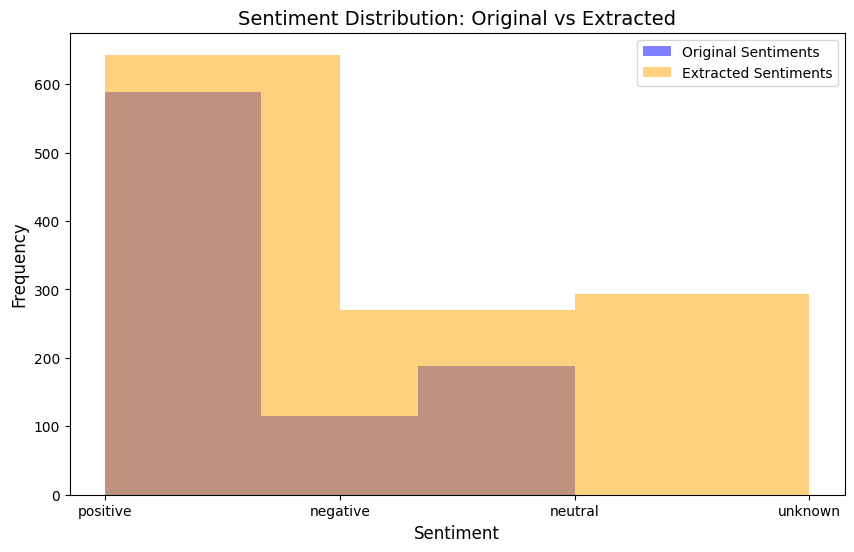

In [179]:
import matplotlib.pyplot as plt

def map_to_primary_sentiment(sentiment):
    """Map complex sentiment labels to primary categories: positive, neutral, negative."""
    if sentiment.lower() in ['positive', 'neutral/positive', 'positive/neutral', 'potential positive']:
        return "positive"
    elif sentiment.lower() in ['neutral', 'mixed', 'positive/negative']:
        return "neutral"
    elif sentiment.lower() in ["negative", "negative/neutral", "negative/potential-reversal", "neutral/negative", 'negative/positive']:
        return "negative"
    else:
        return "unknown"  # If an unknown sentiment label is encountered


# Prepare the sentiment data for original and extracted datasets
# original_sentiments = [map_to_primary_sentiment(insight["sentiment"]) for entry in original_df["insights"] for insight in entry]
extracted_sentiments = [map_to_primary_sentiment(insight["sentiment"]) for entry in extracted_df["insights"] for insight in entry]

# Plotting the histogram
plt.figure(figsize=(10, 6))

# Plot original sentiment distribution
plt.hist(original_sentiments, bins=3, alpha=0.5, label='Original Sentiments', color='blue')

# Plot extracted sentiment distribution
plt.hist(extracted_sentiments, bins=3, alpha=0.5, label='Extracted Sentiments', color='orange')

# Adding titles and labels
plt.title('Sentiment Distribution: Original vs Extracted', fontsize=14)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()

# Display the plot
plt.show()


(array([1380.,  642.,  241.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

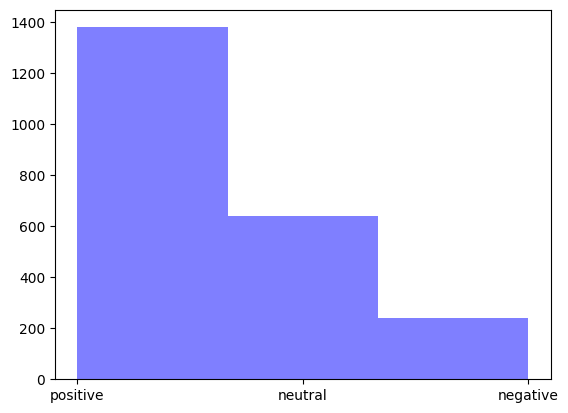

In [168]:
plt.hist(original_sentiments, bins=3, alpha=0.5, label='Original Sentiments', color='blue')

(array([643., 295., 269.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

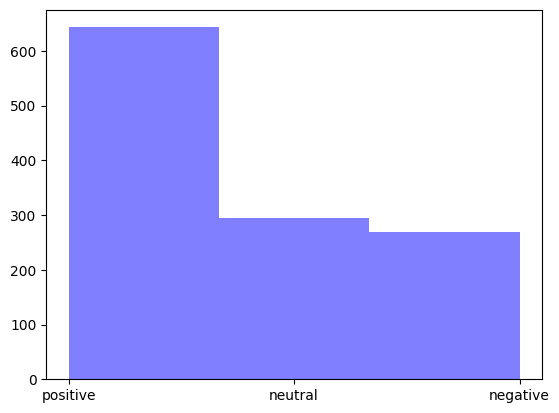

In [169]:
plt.hist(extracted_sentiments, bins=3, alpha=0.5, label='Original Sentiments', color='blue')

# Ticker Eval

In [193]:
original_df[original_df['id']==93]['description'].values

array(['Semiconductor companies are facing challenges due to weakening demand and a worsening correction in Asia, but a soft landing is expected as they are better equipped to navigate the downturn.'],
      dtype=object)

In [190]:
extracted_df[extracted_df['id']==93]

,title,article_keywords,id,tickers,insights
90,Challenges for Semiconductor Companies due to ...,"[Semiconductor companies, Asia, weakening dema...",93,"[QCOM, TXN, INTC, SSNLF, TSM]","[{'company_name': 'Qualcomm Inc.', 'ticker': '..."


In [183]:
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import Counter

# Convert tickers to sets for comparison
original_ticker_sets = {entry["id"]: set(entry["tickers"]) for entry in original_df.to_dict(orient="records")}
extracted_ticker_sets = {entry["id"]: set(entry["tickers"]) for entry in extracted_df.to_dict(orient="records")}

In [184]:
original_ticker_sets

{0: {'ALGT'},
 1: {'AIT', 'NPO'},
 2: {'ARI', 'SAN'},
 3: {'MRVI'},
 4: {'DHT'},
 5: {'META'},
 6: {'CMCSA', 'DIS', 'NFLX', 'WBD'},
 7: {'SRPT'},
 8: {'ATMU', 'DTEGY'},
 9: {'CLDX', 'TFFP'},
 10: {'AAL'},
 11: {'BLBD', 'ZEVY'},
 12: {'HAL'},
 13: {'NFLX'},
 14: {'VZ'},
 15: {'IBIO'},
 16: {'CARR', 'TRMB'},
 17: {'WAFD', 'WAFDP'},
 18: {'PHVS'},
 19: {'NVTAQ'},
 20: {'KBH'},
 21: {'DOCN'},
 22: {'BA', 'DIS', 'WBA'},
 23: {'KBR'},
 24: {'CMA',
  'RF',
  'RFpB',
  'RFpC',
  'RFpE',
  'USB',
  'USBpA',
  'USBpH',
  'USBpP',
  'USBpQ',
  'USBpR',
  'USBpS'},
 25: {'WILYY'},
 26: {'T', 'TBB', 'TBC', 'TpA', 'TpC'},
 27: {'TVTX'},
 28: {'MDLZ'},
 29: {'TRGP'},
 30: {'UPST'},
 31: {'CLNN', 'CLNNW', 'NTWK', 'REKR'},
 32: {'NVDA', 'NXPI'},
 33: {'ARRY', 'SHLS'},
 34: {'ZVRA'},
 35: {'FISI', 'PRA'},
 36: {'GE'},
 37: {'ACGL', 'ACGLN', 'ACGLO', 'KNSL', 'RLI'},
 38: {'ASTS', 'ASTSW', 'BKSY', 'BKSY.WS', 'SPCE'},
 39: {'DNLI'},
 40: {'CHCO'},
 41: {'MFA',
  'MFAN',
  'MFAO',
  'MFApB',
  'MFApC',
  'R

In [185]:
extracted_ticker_sets

{0: {'ALGT'},
 1: {'AIT'},
 2: {'ARI', 'BAC'},
 5: {'FB'},
 6: {'CMCSA'},
 7: {'SRPT'},
 8: {'ATUS', 'DTEGY', 'TAST'},
 10: {'AAL'},
 13: {'NFLX'},
 14: {'VZ'},
 15: {'IBRX'},
 16: {'Ticker not mentioned'},
 17: {'WAFD'},
 18: {'MS'},
 19: {'IVGN'},
 20: {'KBH'},
 21: {'DOCN'},
 22: {'BA', 'DIS', 'WBA'},
 24: {'USB'},
 26: {'T'},
 28: {'MDLZ'},
 29: {'TRGP'},
 30: {'IXIC', 'UPST'},
 31: {'CLNNF', 'NTWK', 'REKR'},
 32: {'NVDA', 'NXPI'},
 36: {'GE'},
 37: {'AXS'},
 38: {'ASTS', 'BKSY', 'SPCE', 'TSLA'},
 39: {'DNLI'},
 40: {'CHCO'},
 41: {'MFA'},
 42: {'ALLY', 'JNJ', 'MDT'},
 43: {'CCI', 'PLD', 'WAL'},
 44: {'MRO'},
 45: {'WBA'},
 46: {'ALLO'},
 47: {'HRTG'},
 48: {'AMZN'},
 49: {'DKNG'},
 50: {'AMZN'},
 51: {'SVM'},
 52: {'FB', 'NVDA', 'TSLA'},
 53: {'M', 'TSLA'},
 56: {'C', 'JPM', 'WFC'},
 57: {'NUS'},
 61: {'CAT', 'CMI', 'FCX'},
 62: {'WEC'},
 63: {'SNAP'},
 64: {'TSLA'},
 65: {'CNX'},
 67: {'XOM'},
 69: {'FSI'},
 70: {'AXSM', 'CRSP', 'PFE'},
 71: {'PANW'},
 72: {'AL'},
 73: {'PM'},
 7

In [182]:


# Ensure both datasets have matching IDs before comparison
matching_ids = set(original_ticker_sets.keys()).intersection(set(extracted_ticker_sets.keys()))

# Prepare evaluation metrics
all_original_tickers = []
all_extracted_tickers = []

jaccard_similarities = []
missing_tickers = []
extra_tickers = []

for article_id in matching_ids:
    original_tickers = original_ticker_sets[article_id]
    extracted_tickers = extracted_ticker_sets[article_id]

    all_original_tickers.extend(original_tickers)
    all_extracted_tickers.extend(extracted_tickers)

    # Compute Jaccard Similarity (Intersection over Union)
    intersection = original_tickers.intersection(extracted_tickers)
    union = original_tickers.union(extracted_tickers)
    jaccard_similarities.append(len(intersection) / len(union) if union else 0)

    # Identify missing and extra tickers
    missing_tickers.extend(original_tickers - extracted_tickers)
    extra_tickers.extend(extracted_tickers - original_tickers)

# Convert to binary format for Precision/Recall calculation
all_original_ticker_counts = Counter(all_original_tickers)
all_extracted_ticker_counts = Counter(all_extracted_tickers)

# Create binary lists
unique_tickers = list(set(all_original_tickers + all_extracted_tickers))
y_true = [1 if ticker in all_original_ticker_counts else 0 for ticker in unique_tickers]
y_pred = [1 if ticker in all_extracted_ticker_counts else 0 for ticker in unique_tickers]

# Calculate Precision, Recall, F1-score
ticker_precision = precision_score(y_true, y_pred, zero_division=0)
ticker_recall = recall_score(y_true, y_pred, zero_division=0)
ticker_f1 = f1_score(y_true, y_pred, zero_division=0)

# Print Evaluation Results
print("\n📊 **Ticker Detection Evaluation:**")
print(f"✅ Jaccard Similarity (Avg): {sum(jaccard_similarities) / len(jaccard_similarities):.4f}")
print(f"✅ Precision: {ticker_precision:.4f}")
print(f"✅ Recall: {ticker_recall:.4f}")
print(f"✅ F1-score: {ticker_f1:.4f}")
print(f"🚨 Missing Tickers: {len(missing_tickers)} (Examples: {missing_tickers[:5]})")



📊 **Ticker Detection Evaluation:**
✅ Jaccard Similarity (Avg): 0.6385
✅ Precision: 0.7749
✅ Recall: 0.5420
✅ F1-score: 0.6379
🚨 Missing Tickers: 971 (Examples: ['NPO', 'SAN', 'META', 'WBD', 'DIS'])
